In [184]:
import re
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [185]:
data = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv')

In [186]:
data.shape

(31962, 3)

In [187]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [188]:
# Delete the "id" column from the dataframe
data = data.drop("id", axis=1)

In [189]:
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [190]:
def remove_pattern(text, pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

In [191]:
data['Tweets'] = np.vectorize(remove_pattern)(data['tweet'], "@[\w]*")
data.head()

,label,tweet,Tweets
0,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


In [192]:
data['Tweets'] = data['Tweets'].str.replace("[^a-zA-Z#]", " ")

In [193]:
data.head(14)

,label,tweet,Tweets
0,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide society now #motivation
5,0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...
6,0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,0,the next school year is the year for exams.ð...,the next school year is the year for exams ...
8,0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land #allin #cavs #champ...
9,0,@user @user welcome here ! i'm it's so #gr...,welcome here i m it s so #gr


In [194]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [195]:
from nltk.corpus import stopwords

data['Tweets'] = data['Tweets'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords.words('english')]))
data.head(14)

,label,tweet,Tweets
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit use cause offer wheelchair...
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ...,#model love u take u time ur
4,0,factsguide: society now #motivation,factsguide society #motivation
5,0,[2/2] huge fan fare and big talking before the...,huge fan fare big talking leave chaos pay disp...
6,0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,0,the next school year is the year for exams.ð...,next school year year exams think #school #exa...
8,0,we won!!! love the land!!! #allin #cavs #champ...,love land #allin #cavs #champions #cleveland #...
9,0,@user @user welcome here ! i'm it's so #gr...,welcome #gr


In [196]:
data['Tweets'] = data['Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

data.head(14)

,label,tweet,Tweets
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause offer wheelchair van...
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ...,#model love take time
4,0,factsguide: society now #motivation,factsguide society #motivation
5,0,[2/2] huge fan fare and big talking before the...,huge fare talking leave chaos disputes #allsho...
6,0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,0,the next school year is the year for exams.ð...,next school year year exams think #school #exa...
8,0,we won!!! love the land!!! #allin #cavs #champ...,love land #allin #cavs #champions #cleveland #...
9,0,@user @user welcome here ! i'm it's so #gr...,welcome


In [197]:
tokenized_tweet = data['Tweets'].apply(lambda x: x.split())
tokenized_tweet.head(14)

0     [father, dysfunctional, selfish, drags, kids, ...
1     [thanks, #lyft, credit, cause, offer, wheelcha...
2                                     [bihday, majesty]
3                            [#model, love, take, time]
4                    [factsguide, society, #motivation]
5     [huge, fare, talking, leave, chaos, disputes, ...
6                            [camping, tomorrow, danny]
7     [next, school, year, year, exams, think, #scho...
8     [love, land, #allin, #cavs, #champions, #cleve...
9                                             [welcome]
10    [#ireland, consumer, price, index, climbed, pr...
11    [selfish, #orlando, #standwithorlando, #pulses...
12                    [daddy, today, days, #gettingfed]
13    [#cnn, calls, #michigan, middle, school, build...
Name: Tweets, dtype: object

In [198]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [199]:
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

tokenized_tweet.head()

0    [father, dysfunctional, selfish, drag, kid, dy...
1    [thanks, #lyft, credit, cause, offer, wheelcha...
2                                    [bihday, majesty]
3                           [#model, love, take, time]
4                   [factsguide, society, #motivation]
Name: Tweets, dtype: object

In [200]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

data['Tweets'] = tokenized_tweet
data.head()

,label,tweet,Tweets
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause offer wheelchair van...
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ...,#model love take time
4,0,factsguide: society now #motivation,factsguide society #motivation


In [201]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [202]:
from nltk import sent_tokenize
from nltk import word_tokenize

text = sent_tokenize(str(data['Tweets']))
#Tokenizing words :
for s in text:
  tokenized_words = word_tokenize(s)
  for words in tokenized_words:
    tagged_words = nltk.pos_tag(tokenized_words)
    
tagged_words

[('0', 'CD'),
 ('father', 'JJ'),
 ('dysfunctional', 'JJ'),
 ('selfish', 'JJ'),
 ('drag', 'NN'),
 ('kid', 'NN'),
 ('dysfunct', 'NN'),
 ('...', ':'),
 ('1', 'CD'),
 ('thanks', 'NNS'),
 ('#', '#'),
 ('lyft', 'JJ'),
 ('credit', 'NN'),
 ('cause', 'NN'),
 ('offer', 'VBP'),
 ('wheelchair', 'NN'),
 ('van', 'NN'),
 ('...', ':'),
 ('2', 'CD'),
 ('bihday', 'NN'),
 ('majesty', 'VBD'),
 ('3', 'CD'),
 ('#', '#'),
 ('model', 'NN'),
 ('love', 'VB'),
 ('take', 'NN'),
 ('time', 'NN'),
 ('4', 'CD'),
 ('factsguide', 'JJ'),
 ('society', 'NN'),
 ('#', '#'),
 ('motivation', 'NN'),
 ('...', ':'),
 ('31957', 'CD'),
 ('youuu', '$'),
 ('31958', 'CD'),
 ('nina', 'JJ'),
 ('turner', 'NN'),
 ('airwave', 'VBP'),
 ('trying', 'VBG'),
 ('wrap', 'NN'),
 ('mantle', 'FW'),
 ('genuine', 'NN'),
 ('...', ':'),
 ('31959', 'CD'),
 ('listening', 'NN'),
 ('song', 'NN'),
 ('monday', 'JJ'),
 ('morning', 'NN'),
 ('work', 'NN'),
 ('31960', 'CD'),
 ('#', '#'),
 ('sikh', 'JJ'),
 ('#', '#'),
 ('temple', 'NN'),
 ('vandalised', 'VBD'),
 (

In [203]:
# Delete the "tweet" column from the dataframe
data = data.drop("tweet", axis=1)

In [204]:
print(data.groupby('label').nunique())

       Tweets
label        
0       26164
1        1829


In [205]:
print(data['Tweets'][3])
print(data['Tweets'][5])
print(data['Tweets'][6])

#model love take time
huge fare talking leave chaos dispute #allshowandnogo
camping tomorrow danny


In [206]:
data['Tweets'] = data['Tweets'].apply(lambda x: x.lower()) 

In [207]:
data['Tweets'] = data['Tweets'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

In [303]:
max_features = 5000

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Tweets'].values)

In [209]:
X = tokenizer.texts_to_sequences(data['Tweets'].values)

In [302]:
print(tokenizer.get_config().keys())
print("tokenizer.word_counts") 
print(tokenizer.word_counts) 
print("tokenizer.document_count")
print(tokenizer.document_count) 
print("tokenizer.word_index")
print(tokenizer.word_index)
print("tokenizer.word_docs")
print(tokenizer.word_docs)
print('Len() of X:', len(X))
print('', X[:2])

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])
tokenizer.word_counts
OrderedDict([('father', 882), ('dysfunctional', 1), ('selfish', 13), ('drag', 9), ('kid', 158), ('dysfunction', 3), ('run', 47), ('thanks', 310), ('lyft', 5), ('credit', 16), ('cause', 78), ('offer', 36), ('wheelchair', 3), ('van', 2), ('disapointed', 1), ('getthanked', 2), ('bihday', 866), ('majesty', 10), ('model', 378), ('love', 2807), ('take', 677), ('time', 1254), ('factsguide', 12), ('society', 34), ('motivation', 175), ('huge', 44), ('fare', 5), ('talking', 67), ('leave', 137), ('chaos', 8), ('dispute', 1), ('allshowandnogo', 1), ('camping', 18), ('tomorrow', 449), ('danny', 7), ('next', 344), ('school', 229), ('year', 549), ('exam', 31), ('think', 433), ('exams', 6), ('hate', 253), ('imagine', 30), ('actorslife', 8), ('revolutionschool', 1), ('girl', 517), ('land', 36), ('allin', 4), ('cavs

In [211]:
for i in range(4):
  print(X[i])
  print('length=', len(X[i]))

[10, 187, 731]
length= 3
[76, 1878, 413, 912]
length= 4
[11]
length= 1
[60, 1, 17, 3]
length= 4


In [212]:
X = pad_sequences(X) 
print('X.shape = ', X.shape)

X.shape =  (31962, 16)


In [213]:
for i in range(4):
  print(X[i])
  print('length=', len(X[i]))

[  0   0   0   0   0   0   0   0   0   0   0   0   0  10 187 731]
length= 16
[   0    0    0    0    0    0    0    0    0    0    0    0   76 1878
  413  912]
length= 16
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11]
length= 16
[ 0  0  0  0  0  0  0  0  0  0  0  0 60  1 17  3]
length= 16


In [230]:
embed_dim = 256
lstm_out = 342

In [232]:
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['label'])
y = to_categorical(integer_encoded)

In [304]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [315]:
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))

In [316]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [317]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 16, 256)           1280000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 342)               819432    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 686       
Total params: 2,100,118
Trainable params: 2,100,118
Non-trainable params: 0
_________________________________________________________________


In [320]:
batch_size = 256
epochs = 2

In [321]:
history = model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=epochs, batch_size=batch_size, verbose = 1)

for key in history.history:
    print(key)

Epoch 1/2
94/94 [==============================] - 73s 778ms/step - loss: 0.1462 - accuracy: 0.9490 - val_loss: 0.1381 - val_accuracy: 0.9523
Epoch 2/2
94/94 [==============================] - 72s 762ms/step - loss: 0.1130 - accuracy: 0.9589 - val_loss: 0.1402 - val_accuracy: 0.9542
loss
accuracy
val_loss
val_accuracy


In [324]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.2f%%" % (scores[0]*100))

Accuracy: 95.42%
Loss: 14.02%


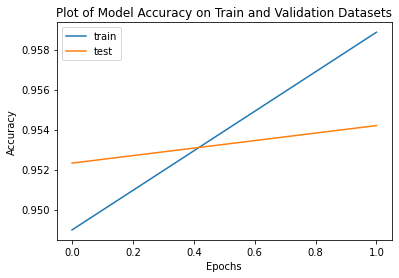

In [325]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Plot of Model Accuracy on Train and Validation Datasets')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

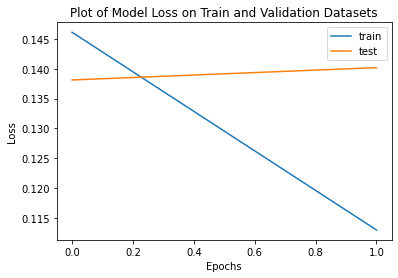

In [326]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot of Model Loss on Train and Validation Datasets')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()